# USPS Housing Vacancy Counts and Census Counts

The United States Department of Housing and Urban Development (HUD) currently has an agreement with the United States Postal Service (USPS) to receive quarterly aggregated data on addresses identified by the USPS as having been "Vacant" or "No-Stat" in the previous quarter. Here, we attempt to compare the dataset to the housing counts in the 2020 Census.

The data is protected and requires a brief application for use. For the purposes of this analysis, we selected data for the quarter ending on June 30, 2020.

Before analyzing 2020 data, we are focused on comparing 2010 Census data to 2010 USPS data. Here I obtain the 2010 county-level housing counts from 2010 Census, using the Census API. 


In [1]:
from census import Census
from us import states
import pandas as pd

c = Census("c629512146490e65d1c8ffc1dd8f3414872810b3")


chousing_2010 = c.pl.state_county(
    (
        "NAME",
        "P001001",
        "H001001",
        "H001002",
        "H001003",
    ),
    states.NC.fips,
    "*",
    year=2010,
)

# Convert to DataFrame
chousing_2010 = pd.DataFrame(chousing_2010)

#  Remove 'North Carolina' from column names
chousing_2010["NAME"] = (
    chousing_2010["NAME"]
    .str.replace(", North Carolina", "")
)


# Rename variables as appropriate
chousing_2010 = chousing_2010.rename(
    {
        "NAME": "county_and_tra",
        "P001001": "pop_count",
        "state": "state_fips",
        "county": "county_fips",
        "H001001": "total_housing",
        "H001002": "occ_housing",
        "H001003": "vacant_housing",
    },
    axis=1,
)
chousing_2010["full_fips"] = chousing_2010["state_fips"] + chousing_2010["county_fips"]


Next, I read in the 2010 USPS Vacancy data and did some brief cleaning.

In [2]:
import geopandas as gpd

gdf = gpd.read_file("../00_source_data/2010_vacancy_usps.dbf")
gdf_cols = [
    "GEOID",
    "AMS_RES",
    "RES_VAC",
    "PQV_IS_RES",
    "PQV_NS_RES",
    "NOSTAT_RES",
    "AVG_VAC_R",
    "AVG_NS_RES",
]
gdf = gdf[gdf_cols]
gdf = gdf[gdf["GEOID"].astype(str).str[0:2] == "37"]
gdf["fips"] = gdf["GEOID"].astype(str).str[0:5]
gdf = gdf.groupby("fips").sum().reset_index()
housing_2010 = pd.merge(
    gdf,
    chousing_2010,
    how="outer",
    validate="1:1",
    indicator=True,
    left_on="fips",
    right_on="full_fips",
)
housing_2010["usps_occ_VNS"] = housing_2010["AMS_RES"] - housing_2010["RES_VAC"] - housing_2010["NOSTAT_RES"]
housing_2010["usps_occ_V"] = housing_2010["AMS_RES"] - housing_2010["RES_VAC"]
housing_2010["usps_occ_NS"] = housing_2010["AMS_RES"] - housing_2010["NOSTAT_RES"]
housing_2010["perc_diff_VNS"] = 100 * (housing_2010["usps_occ_VNS"] - housing_2010["occ_housing"]) / housing_2010["occ_housing"]
housing_2010["perc_diff_V"] = 100 * (housing_2010["usps_occ_V"] - housing_2010["occ_housing"]) / housing_2010["occ_housing"]
housing_2010["perc_diff_NS"] = 100 * (housing_2010["usps_occ_NS"] - housing_2010["occ_housing"]) / housing_2010["occ_housing"]


In [3]:
housing_2010[["perc_diff_VNS", "perc_diff_V", "perc_diff_NS"]].describe()

,perc_diff_VNS,perc_diff_V,perc_diff_NS
count,100.000000,100.000000,100.000000
mean,-5.733327,10.225516,-3.812542
std,10.538452,13.273003,11.305563
min,-43.511090,-24.420755,-43.511090
25%,-10.186181,5.374396,-7.928671
50%,-3.820156,10.027062,-1.578897
75%,1.850158,14.105630,4.376916
max,13.878418,76.601362,15.118909


In [4]:
# read in shapefile
shape = gpd.read_file("../00_source_data/cb_2018_us_county_20m")
# limit to NC
shape = shape[shape["STATEFP"] == "37"]
shape = shape[["COUNTYFP", "geometry"]]
# merge w/ vacancy/counts
shape["COUNTYFP"] = shape["COUNTYFP"].astype(int)
housing_2010["county_fips"] = housing_2010["county_fips"].astype(int)
vac_geo = shape.merge(
    housing_2010, how="left", left_on="COUNTYFP", validate="1:1", right_on="county_fips", indicator=True
)

ValueError: Cannot use name of an existing column for indicator column

In [ ]:
import geopandas as gpd
import pandas as pd
from census import Census
from us import states
import matplotlib.pyplot as plt

# import vacancy and population
gdf = gpd.read_file("../00_source_data/usps_vac_062020_tractsum_2kx.dbf")
counts = pd.read_csv("../00_source_data/2020_counts_NC.csv")
# subset to relevant cols
gdf_cols = [
    "geoid",
    "ams_res",
    "res_vac",
    "pqv_is_res",
    "pqv_ns_res",
    "nostat_res",
    "avg_vac_r",
    "avg_ns_res",
]
counts_cols = [
    "county",
    "total_housing",
    "occ_housing",
    "unocc_housing",
    "county_fips",
]
gdf = gdf[gdf_cols]
counts = counts[counts_cols]


In [ ]:
counts.head()

,county,total_housing,occ_housing,unocc_housing,county_fips
0,Anson County,9834.0,8554.0,1280.0,7
1,Beaufort County,24090.0,19430.0,4660.0,13
2,Brunswick County,88330.0,61496.0,26834.0,19
3,Cabarrus County,87410.0,82596.0,4814.0,25
4,Carteret County,50846.0,30112.0,20734.0,31


In [ ]:
# extract state and county fips
gdf["statefips"] = gdf["geoid"].astype(str).str[0:2]
gdf["countyfips"] = gdf["geoid"].astype(str).str[2:5].astype(int)
# limit to north carolina
gdf = gdf[gdf["statefips"] == "37"]
# aggregate to county level (by summing)
gdf = gdf.groupby(["countyfips"]).sum().reset_index()
# merge datasets
merged = counts.merge(gdf, left_on="county_fips", right_on="countyfips", validate="1:1").drop(["countyfips"], axis=1)


In [ ]:
# read in shapefile
shape = gpd.read_file("../00_source_data/cb_2018_us_county_20m")
# limit to NC
shape = shape[shape["STATEFP"] == "37"]
shape = shape[["COUNTYFP", "geometry"]]
# merge w/ vacancy/counts
shape["COUNTYFP"] = shape["COUNTYFP"].astype(int)
vac_geo = shape.merge(
    merged, how="left", left_on="COUNTYFP", validate="1:1", right_on="county_fips", indicator=True
)


In [ ]:
vac_geo.dtypes

COUNTYFP            int64
geometry         geometry
county             object
total_housing     float64
occ_housing       float64
unocc_housing     float64
county_fips         int64
ams_res             int64
res_vac             int64
pqv_is_res          int64
pqv_ns_res          int64
nostat_res          int64
avg_vac_r         float64
avg_ns_res        float64
_merge           category
dtype: object

In [ ]:
# create variables
# USPS estimate of occupied housing
vac_geo["housing_usps"] = (
    vac_geo["ams_res"] - vac_geo["nostat_res"] - vac_geo["res_vac"]
)
# % diff between Census and USPS
vac_geo["perc_diff"] = (
    100 * (vac_geo["occ_housing"] - vac_geo["housing_usps"]) / vac_geo["housing_usps"]
)
# % of total housing units coming back on
vac_geo["perc_back"] = 100*vac_geo["pqv_is_res"] / vac_geo["ams_res"]

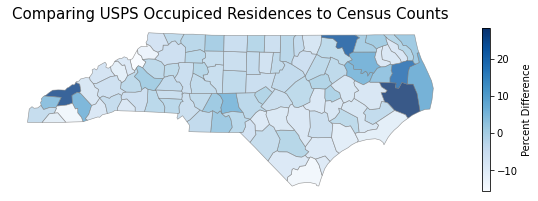

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 20))
vac_geo.plot(
    column="perc_diff",
    cmap="Blues",
    legend=True,
    legend_kwds={"shrink": 0.15, "label": "Percent Difference"},
    missing_kwds={
        "color": "grey",
        "label": "Missing values",
    },
    alpha=0.8,
    edgecolor="#808080",
    linewidth=0.6,
    ax=ax,
)
ax.set_axis_off()
ax.set_title(label="Comparing USPS Occupiced Residences to Census Counts", size=15)
plt.show()
plt.savefig("USPS.png", bbox_inches="tight", dpi=400)